In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Basics') \
        .getOrCreate()

print(spark.version)

3.5.4


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Assign home directory
home_dir = 'C:/Users/gyalm/OneDrive/Desktop/churn_prediction/churn_prediction'

In [3]:
# Define functions
# Import additional packages
import datetime
import csv
import yaml
import io
import dill as pickle
import os

def get_datetime():
    """Returns datetime for filename use.

    :return: datetime
    :rtype: string
    """
    stamp = datetime.datetime.now()
    datetime_name = f"{stamp.year:04}{stamp.month:02}{stamp.day:02}_{stamp.hour:02}{stamp.minute:02}"
    print(datetime_name)
    return datetime_name

print('Functions ready!')

Functions ready!


In [4]:
df_2018 = spark.read.csv(f"C:/Users/gyalm/OneDrive/Desktop/churn_prediction/churn_prediction/data/week8_student_project.csv.gz", inferSchema=True, header=True)
df_2018.show(10)
df_2018.createOrReplaceTempView("df_2018_view")

+----------------+-----------+------+--------------------+-----------------+----------------+------+-------+--------+--------+------+-----+---------+------------+---------+--------------------+----------------+-------------+-----------+------+-------------+
|transaction_date|member_type|branch|           member_id|transaction_month|transaction_year|gender|product|quantity|category|amount|  age|card_type|weather_date|branch_id|        weather_list|temperature_list|realfell_list|branch_name|region|category_name|
+----------------+-----------+------+--------------------+-----------------+----------------+------+-------+--------+--------+------+-----+---------+------------+---------+--------------------+----------------+-------------+-----------+------+-------------+
|      2018-04-01|     member|     E|ff96777d-cfda-11e...|              APR|            2018|FEMALE|   3267|      16|     127|  5100|30-35|  REGULAR|  2018-04-01|        E|       Partly cloudy|              24|           28|  

In [5]:
# Check products in categories
spark.sql('''
SELECT
  product, category_name
FROM
  df_2018_view
''').show()

+-------+-------------+
|product|category_name|
+-------+-------------+
|   3267|  FROZEN FOOD|
|   6748|          PET|
|    420|          PET|
|   3178|      GADGETS|
|   2727|      CLOTHES|
|   2451|      CLOTHES|
|   2998|     CLEANERS|
|   3182|  ACCESSORIES|
|   2597|     CLEANERS|
|   2584|     CLEANERS|
|   2926|      CLOTHES|
|    420|          PET|
|   2666|     HARDWARE|
|    420|          PET|
|   3247|   APPLIANCES|
|   3076|     CLEANERS|
|  10000|     CLEANERS|
|   2679|      GADGETS|
|   3026|  ACCESSORIES|
|   3311|     HARDWARE|
+-------+-------------+
only showing top 20 rows



In [6]:
# Check total product quantity count
spark.sql('''
SELECT DISTINCT COUNT(product) AS total_cnt_product
FROM
  df_2018_view
''').show()

+-----------------+
|total_cnt_product|
+-----------------+
|          4355328|
+-----------------+



In [7]:
# Aggregate total quantity of each product from each category from 2018 to 2019
spark.sql('''
SELECT
    DATE_FORMAT(transaction_date, 'yyyy-MM') AS month,
    product,
    category_name,
    SUM(quantity) AS total_quantity
FROM df_2018_view
WHERE transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
GROUP BY month, product, category_name
ORDER BY month, total_quantity ASC
''').show()


+-------+-------+-------------+--------------+
|  month|product|category_name|total_quantity|
+-------+-------+-------------+--------------+
|2018-01|   1978|   APPLIANCES|             1|
|2018-01|    837|  ACCESSORIES|             1|
|2018-01|   5917|   APPLIANCES|             1|
|2018-01|   2127|          PET|             1|
|2018-01|   2095|   APPLIANCES|             1|
|2018-01|   3570|          PET|             1|
|2018-01|   6314|  FROZEN FOOD|             1|
|2018-01|   6616|  ACCESSORIES|             1|
|2018-01|   6939|          PET|             1|
|2018-01|   9663|          PET|             1|
|2018-01|   4268|        SHOES|             1|
|2018-01|   7757|        SHOES|             1|
|2018-01|   6840|      GADGETS|             1|
|2018-01|   3249|      GADGETS|             1|
|2018-01|   6541|        SHOES|             1|
|2018-01|   3194|   APPLIANCES|             1|
|2018-01|   3915|   APPLIANCES|             1|
|2018-01|   3181|     CLEANERS|             1|
|2018-01|   7

In [8]:
# Show only the product and category with lowest quantity per month from 2018 to 2019
spark.sql('''
WITH monthly_product_quantity AS (
    SELECT
        DATE_FORMAT(transaction_date, 'yyyy-MM') AS month,
        product,
        category_name,
        SUM(quantity) AS total_quantity
    FROM df_2018_view
    WHERE transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
    GROUP BY month, product, category_name
),
lowest_quantity_per_month AS (
    SELECT *
    FROM (
        SELECT *,
               ROW_NUMBER() OVER (PARTITION BY month ORDER BY total_quantity ASC) AS rn
        FROM monthly_product_quantity
    ) ranked
    WHERE rn = 1
)

SELECT month, product, category_name, total_quantity
FROM lowest_quantity_per_month
ORDER BY month DESC
''').show()

+-------+-------+-------------+--------------+
|  month|product|category_name|total_quantity|
+-------+-------+-------------+--------------+
|2019-12|   3765|   APPLIANCES|             1|
|2019-11|    606|      GADGETS|             1|
|2019-10|   7166|  ACCESSORIES|             1|
|2019-08|   1321|      CLOTHES|             1|
|2019-07|   4618|          PET|             1|
|2019-06|   3201|  FROZEN FOOD|             4|
|2019-05|   6528|     HARDWARE|             2|
|2019-04|   9360|         FOOD|             1|
|2019-03|   7060|      GADGETS|             1|
|2019-02|   2091|     CLEANERS|             1|
|2019-01|   1655|        SHOES|             1|
|2018-12|   5884|        SHOES|             1|
|2018-11|   9649|   APPLIANCES|             1|
|2018-10|   4821|         FOOD|             1|
|2018-08|   1157|  FROZEN FOOD|             1|
|2018-07|   2917|  ACCESSORIES|             1|
|2018-06|    311|  FROZEN FOOD|             1|
|2018-05|   3288|   APPLIANCES|             4|
|2018-04|   8

In [9]:
# Show only category with lowest aggregated quantity per month from 2018 to 2019
spark.sql('''
WITH monthly_category_quantity AS (
    SELECT
        DATE_FORMAT(transaction_date, 'yyyy-MM') AS month,
        category_name,
        SUM(quantity) AS total_quantity
    FROM df_2018_view
    WHERE transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
    GROUP BY month, category_name
),
lowest_category_per_month AS (
    SELECT *
    FROM (
        SELECT *,
               ROW_NUMBER() OVER (PARTITION BY month ORDER BY total_quantity ASC) AS rn
        FROM monthly_category_quantity
    ) ranked
    WHERE rn = 1
)

SELECT month, category_name, total_quantity
FROM lowest_category_per_month
ORDER BY month
''').show()

+-------+-------------+--------------+
|  month|category_name|total_quantity|
+-------+-------------+--------------+
|2018-01|      GADGETS|         26662|
|2018-02|         FOOD|        130403|
|2018-03|        SHOES|        153614|
|2018-04|         FOOD|        131663|
|2018-05|  FROZEN FOOD|        206295|
|2018-06|      CLOTHES|        182339|
|2018-07|        SHOES|         59055|
|2018-08|   APPLIANCES|         29084|
|2018-10|        SHOES|        135030|
|2018-11|         FOOD|         91249|
|2018-12|        SHOES|        196027|
|2019-01|      GADGETS|         26417|
|2019-02|         FOOD|        130408|
|2019-03|        SHOES|        151125|
|2019-04|         FOOD|        132215|
|2019-05|  FROZEN FOOD|        203060|
|2019-06|      CLOTHES|        184974|
|2019-07|        SHOES|         60145|
|2019-08|   APPLIANCES|         30121|
|2019-10|        SHOES|        136645|
+-------+-------------+--------------+
only showing top 20 rows



In [10]:
# Show only the product with lowest quantity per month and where category is gadgets from 2018 to 2019
spark.sql('''
WITH monthly_product_quantity AS (
    SELECT
        DATE_FORMAT(transaction_date, 'yyyy-MM') AS month,
        product,
        category_name,
        SUM(quantity) AS total_quantity
    FROM df_2018_view
    WHERE transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
      AND category_name = 'GADGETS'
    GROUP BY month, product, category_name
),
lowest_quantity_per_month AS (
    SELECT *
    FROM (
        SELECT *,
               ROW_NUMBER() OVER (PARTITION BY month ORDER BY total_quantity ASC) AS rn
        FROM monthly_product_quantity
    ) ranked
    WHERE rn = 1
)

SELECT month, product, category_name, total_quantity
FROM lowest_quantity_per_month
ORDER BY month ASC
''').show()

+-------+-------+-------------+--------------+
|  month|product|category_name|total_quantity|
+-------+-------+-------------+--------------+
|2018-01|   6840|      GADGETS|             1|
|2018-02|   7319|      GADGETS|             1|
|2018-03|   6597|      GADGETS|             2|
|2018-04|   8126|      GADGETS|             1|
|2018-05|   8107|      GADGETS|            13|
|2018-06|   2804|      GADGETS|            12|
|2018-07|   1197|      GADGETS|             1|
|2018-08|   1407|      GADGETS|             1|
|2018-10|   5006|      GADGETS|             1|
|2018-11|   6192|      GADGETS|             1|
|2018-12|   7818|      GADGETS|            13|
|2019-01|   2145|      GADGETS|             1|
|2019-02|   4056|      GADGETS|             2|
|2019-03|   7060|      GADGETS|             1|
|2019-04|   2089|      GADGETS|             2|
|2019-05|   7730|      GADGETS|            10|
|2019-06|   7726|      GADGETS|             7|
|2019-07|   9253|      GADGETS|             1|
|2019-08|   7

In [11]:
# Show products in chosen category
spark.sql('''
SELECT DISTINCT product FROM df_2018_view WHERE category_name = 'GADGETS'
''').show()

+-------+
|product|
+-------+
|   2866|
|   3749|
|   9900|
|   2659|
|   6357|
|   9427|
|   2999|
|   4929|
|   8105|
|   2580|
|   1339|
|   1699|
|   5984|
|   2443|
|   3876|
|   4078|
|   1975|
|   9169|
|   6597|
|   7066|
+-------+
only showing top 20 rows



In [12]:
# Check partition dates
spark.sql('''
SELECT
   MIN(transaction_date)
  ,MAX(transaction_date)
FROM
  df_2018_view
''').show()

+---------------------+---------------------+
|min(transaction_date)|max(transaction_date)|
+---------------------+---------------------+
|           2018-01-01|           2019-12-31|
+---------------------+---------------------+



In [13]:
# Count transactions in 2018
spark.sql('''
SELECT
   COUNT(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-01-31' THEN 1 ELSE NULL END) AS jan_2018_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-02-28' THEN 1 ELSE NULL END) AS feb_2018_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-03-01' AND '2018-03-31' THEN 1 ELSE NULL END) AS mar_2018_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-04-01' AND '2018-04-30' THEN 1 ELSE NULL END) AS apr_2018_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-05-01' AND '2018-05-31' THEN 1 ELSE NULL END) AS may_2018_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-06-01' AND '2018-06-30' THEN 1 ELSE NULL END) AS jun_2018_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-07-01' AND '2018-07-31' THEN 1 ELSE NULL END) AS jul_2018_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-08-01' AND '2018-08-30' THEN 1 ELSE NULL END) AS aug_2018_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-09-01' AND '2018-09-31' THEN 1 ELSE NULL END) AS sep_2018_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-10-01' AND '2018-10-31' THEN 1 ELSE NULL END) AS oct_2018_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-11-01' AND '2018-11-30' THEN 1 ELSE NULL END) AS nov_2018_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-12-01' AND '2018-12-31' THEN 1 ELSE NULL END) AS dec_2018_txns
FROM
  df_2018_view
''').show()

+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|jan_2018_txns|feb_2018_txns|mar_2018_txns|apr_2018_txns|may_2018_txns|jun_2018_txns|jul_2018_txns|aug_2018_txns|sep_2018_txns|oct_2018_txns|nov_2018_txns|dec_2018_txns|
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|       190117|       187789|       228579|       204935|       308383|       292253|        94626|        42902|            0|       203725|       133960|       291739|
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+



In [14]:
# Count transactions in 2018
spark.sql('''
SELECT
   COUNT(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-12-31' THEN 1 ELSE NULL END) AS 2018_txns
FROM
  df_2018_view
''').show()

+---------+
|2018_txns|
+---------+
|  2179008|
+---------+



In [15]:
# Count transactions in 2019
spark.sql('''
SELECT
   COUNT(CASE WHEN transaction_date BETWEEN '2019-01-01' AND '2019-01-31' THEN 1 ELSE NULL END) AS jan_2019_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-02-01' AND '2019-02-28' THEN 1 ELSE NULL END) AS feb_2019_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-03-01' AND '2019-03-31' THEN 1 ELSE NULL END) AS mar_2019_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-04-01' AND '2019-04-30' THEN 1 ELSE NULL END) AS apr_2019_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-05-01' AND '2019-05-31' THEN 1 ELSE NULL END) AS may_2019_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-06-01' AND '2019-06-30' THEN 1 ELSE NULL END) AS jun_2019_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-07-01' AND '2019-07-31' THEN 1 ELSE NULL END) AS jul_2019_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-08-01' AND '2019-08-30' THEN 1 ELSE NULL END) AS aug_2019_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-09-01' AND '2019-09-31' THEN 1 ELSE NULL END) AS sep_2019_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-10-01' AND '2019-10-31' THEN 1 ELSE NULL END) AS oct_2019_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-11-01' AND '2019-11-30' THEN 1 ELSE NULL END) AS nov_2019_txns,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-12-01' AND '2019-12-31' THEN 1 ELSE NULL END) AS dec_2019_txns
FROM
  df_2018_view
''').show()

+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|jan_2019_txns|feb_2019_txns|mar_2019_txns|apr_2019_txns|may_2019_txns|jun_2019_txns|jul_2019_txns|aug_2019_txns|sep_2019_txns|oct_2019_txns|nov_2019_txns|dec_2019_txns|
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|       188948|       188600|       227770|       204166|       307653|       292714|        95046|        42823|            0|       205764|       132435|       290401|
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+



In [16]:
# Count transactions in 2019
spark.sql('''
SELECT
   COUNT(CASE WHEN transaction_date BETWEEN '2019-01-01' AND '2019-12-31' THEN 1 ELSE NULL END) AS 2019_txns
FROM
  df_2018_view
''').show()

+---------+
|2019_txns|
+---------+
|  2176320|
+---------+



In [17]:
# Revenue comparison of product 7730 on the overall GADGETS category
spark.sql('''
WITH monthly_product_revenue AS (
    SELECT
        DATE_TRUNC('month', transaction_date) AS month,
        product,
        category_name,
        SUM(quantity * amount) AS total_revenue
    FROM 
        df_2018_view
    WHERE 
        transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
        AND category_name = 'GADGETS'
    GROUP BY 
        month, product, category_name
),

total_gadgets_revenue AS (
    SELECT
        month,
        SUM(total_revenue) AS total_gadgets_revenue
    FROM 
        monthly_product_revenue
    GROUP BY 
        month
),

product_7730_revenue AS (
    SELECT
        month,
        total_revenue AS product_7730_revenue
    FROM 
        monthly_product_revenue
    WHERE 
        product = '7730'
)

SELECT 
    p7730.month,
    p7730.product_7730_revenue,
    tgr.total_gadgets_revenue,
    ROUND(
        (p7730.product_7730_revenue / tgr.total_gadgets_revenue) * 100, 2
    ) AS revenue_percentage
FROM 
    product_7730_revenue p7730
JOIN 
    total_gadgets_revenue tgr
    ON p7730.month = tgr.month
ORDER BY 
    p7730.month ASC
''').show()

+-------------------+--------------------+---------------------+------------------+
|              month|product_7730_revenue|total_gadgets_revenue|revenue_percentage|
+-------------------+--------------------+---------------------+------------------+
|2018-01-01 00:00:00|              266400|            132274900|               0.2|
|2018-02-01 00:00:00|              384800|            601711300|              0.06|
|2018-03-01 00:00:00|              325600|            906617600|              0.04|
|2018-04-01 00:00:00|              503200|            699450800|              0.07|
|2018-05-01 00:00:00|              717800|           1084563600|              0.07|
|2018-06-01 00:00:00|              865800|            973753400|              0.09|
|2018-07-01 00:00:00|              133200|            350401700|              0.04|
|2018-08-01 00:00:00|               14800|            161278700|              0.01|
|2018-10-01 00:00:00|             8473000|            676094000|            

<Figure size 1200x600 with 0 Axes>

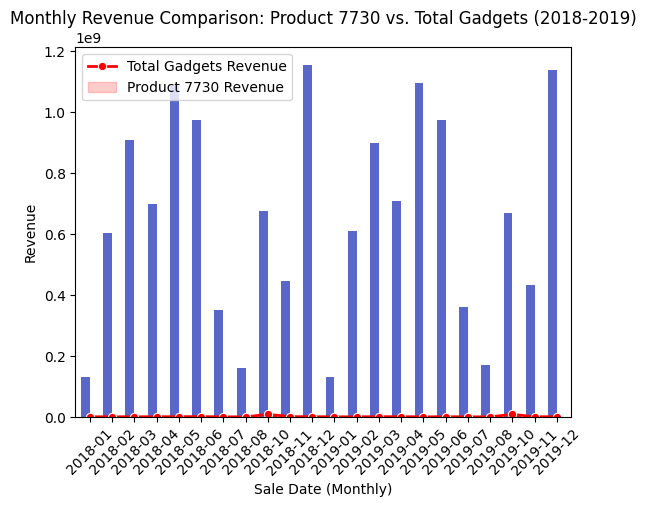

In [18]:
# Monthly Revenue Comparison: Product 7730 vs. Total Gadgets (2018-2019)

df = spark.sql('''
WITH monthly_product_revenue AS ( 
    SELECT
        DATE_TRUNC('month', transaction_date) AS sale_date,
        product,
        category_name,
        SUM(quantity * amount) AS total_revenue
    FROM 
        df_2018_view
    WHERE 
        transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
        AND category_name = 'GADGETS'
    GROUP BY 
        sale_date, product, category_name
),

total_gadgets_revenue AS (
    SELECT
        sale_date,
        SUM(total_revenue) AS total_gadgets_revenue
    FROM 
        monthly_product_revenue
    GROUP BY 
        sale_date
),

product_7730_revenue AS (
    SELECT
        sale_date,
        SUM(total_revenue) AS product_7730_revenue
    FROM 
        monthly_product_revenue
    WHERE 
        product = '7730'
    GROUP BY 
        sale_date
)

SELECT 
    tgr.sale_date,
    COALESCE(p7730.product_7730_revenue, 0) AS product_7730_revenue,
    COALESCE(tgr.total_gadgets_revenue, 0) AS total_gadgets_revenue
FROM 
    total_gadgets_revenue tgr
LEFT JOIN 
    product_7730_revenue p7730
    ON tgr.sale_date = p7730.sale_date
ORDER BY 
    tgr.sale_date ASC;
''')

df_pandas = df.toPandas()

df_pandas["sale_date"] = pd.to_datetime(df_pandas["sale_date"]).dt.strftime('%Y-%m') 

df_pandas.set_index("sale_date", inplace=True)

plt.figure(figsize=(12, 6))
df_pandas[["total_gadgets_revenue", "product_7730_revenue"]].plot(kind="bar", width=0.8, colormap="coolwarm", alpha=0.85)

ax = plt.gca()

# sns.lineplot(
#     data=df_pandas, 
#     x=df_pandas.index, 
#     y="total_gadgets_revenue", 
#     marker="o", color="blue", linewidth=2, label="Product 7730 Trend", ax=ax
# )

sns.lineplot(
    data=df_pandas, 
    x=df_pandas.index, 
    y="product_7730_revenue", 
    marker="o", color="red", linewidth=2, label="Product 7730 Trend", ax=ax
)

plt.xlabel("Sale Date (Monthly)")
plt.ylabel("Revenue")
plt.title("Monthly Revenue Comparison: Product 7730 vs. Total Gadgets (2018-2019)")
plt.xticks(rotation=45)
plt.legend(["Total Gadgets Revenue", "Product 7730 Revenue"], loc="upper left")

plt.show()

<Figure size 1200x600 with 0 Axes>

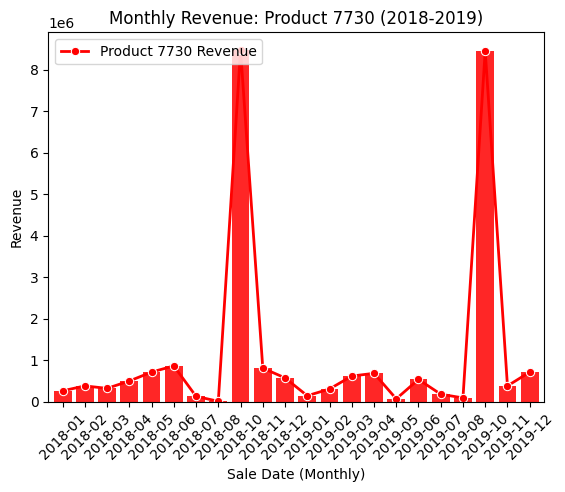

In [19]:
df = spark.sql('''
WITH monthly_product_revenue AS ( 
    SELECT
        DATE_TRUNC('month', transaction_date) AS sale_date,
        product,
        category_name,
        SUM(quantity * amount) AS total_revenue
    FROM 
        df_2018_view
    WHERE 
        transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
        AND category_name = 'GADGETS'
    GROUP BY 
        sale_date, product, category_name
),

total_gadgets_revenue AS (
    SELECT
        sale_date,
        SUM(total_revenue) AS total_gadgets_revenue
    FROM 
        monthly_product_revenue
    GROUP BY 
        sale_date
),

product_7730_revenue AS (
    SELECT
        sale_date,
        SUM(total_revenue) AS product_7730_revenue
    FROM 
        monthly_product_revenue
    WHERE 
        product = '7730'
    GROUP BY 
        sale_date
)

SELECT 
    tgr.sale_date,
    COALESCE(p7730.product_7730_revenue, 0) AS product_7730_revenue,
    COALESCE(tgr.total_gadgets_revenue, 0) AS total_gadgets_revenue
FROM 
    total_gadgets_revenue tgr
LEFT JOIN 
    product_7730_revenue p7730
    ON tgr.sale_date = p7730.sale_date
ORDER BY 
    tgr.sale_date ASC;
''')

df_pandas = df.toPandas()

df_pandas["sale_date"] = pd.to_datetime(df_pandas["sale_date"]).dt.strftime('%Y-%m') 

df_pandas.set_index("sale_date", inplace=True)

plt.figure(figsize=(12, 6))
df_pandas[["product_7730_revenue"]].plot(kind="bar", width=0.8, color="red", alpha=0.85)

ax = plt.gca()

# sns.lineplot(
#     data=df_pandas, 
#     x=df_pandas.index, 
#     y="total_gadgets_revenue", 
#     marker="o", color="blue", linewidth=2, label="Product 7730 Trend", ax=ax
# )

sns.lineplot(
    data=df_pandas, 
    x=df_pandas.index, 
    y="product_7730_revenue", 
    marker="o", color="red", linewidth=2, label="Product 7730 Trend", ax=ax
)

plt.xlabel("Sale Date (Monthly)")
plt.ylabel("Revenue")
plt.title("Monthly Revenue: Product 7730 (2018-2019)")
plt.xticks(rotation=45)
plt.legend(["Product 7730 Revenue"], loc="upper left")

plt.show()

<Figure size 1200x600 with 0 Axes>

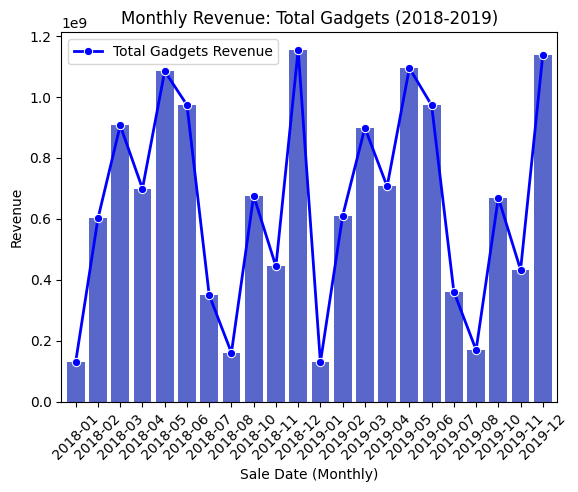

In [20]:
df = spark.sql('''
WITH monthly_product_revenue AS ( 
    SELECT
        DATE_TRUNC('month', transaction_date) AS sale_date,
        product,
        category_name,
        SUM(quantity * amount) AS total_revenue
    FROM 
        df_2018_view
    WHERE 
        transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
        AND category_name = 'GADGETS'
    GROUP BY 
        sale_date, product, category_name
),

total_gadgets_revenue AS (
    SELECT
        sale_date,
        SUM(total_revenue) AS total_gadgets_revenue
    FROM 
        monthly_product_revenue
    GROUP BY 
        sale_date
),

product_7730_revenue AS (
    SELECT
        sale_date,
        SUM(total_revenue) AS product_7730_revenue
    FROM 
        monthly_product_revenue
    WHERE 
        product = '7730'
    GROUP BY 
        sale_date
)

SELECT 
    tgr.sale_date,
    COALESCE(p7730.product_7730_revenue, 0) AS product_7730_revenue,
    COALESCE(tgr.total_gadgets_revenue, 0) AS total_gadgets_revenue
FROM 
    total_gadgets_revenue tgr
LEFT JOIN 
    product_7730_revenue p7730
    ON tgr.sale_date = p7730.sale_date
ORDER BY 
    tgr.sale_date ASC;
''')

df_pandas = df.toPandas()

df_pandas["sale_date"] = pd.to_datetime(df_pandas["sale_date"]).dt.strftime('%Y-%m') 

df_pandas.set_index("sale_date", inplace=True)

plt.figure(figsize=(12, 6))
df_pandas[["total_gadgets_revenue"]].plot(kind="bar", width=0.8, colormap="coolwarm", alpha=0.85)

ax = plt.gca()

sns.lineplot(
    data=df_pandas, 
    x=df_pandas.index, 
    y="total_gadgets_revenue", 
    marker="o", color="blue", linewidth=2, label="Product 7730 Trend", ax=ax
)

# sns.lineplot(
#     data=df_pandas, 
#     x=df_pandas.index, 
#     y="product_7730_revenue", 
#     marker="o", color="red", linewidth=2, label="Product 7730 Trend", ax=ax
# )

plt.xlabel("Sale Date (Monthly)")
plt.ylabel("Revenue")
plt.title("Monthly Revenue: Total Gadgets (2018-2019)")
plt.xticks(rotation=45)
plt.legend(["Total Gadgets Revenue"], loc="upper left")

plt.show()

In [21]:
# Count product 7730 transactions in 2018
spark.sql('''
SELECT
   COUNT(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-01-31' AND product = 7730 THEN 1 ELSE NULL END) AS jan_2018_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-02-28' AND product = 7730 THEN 1 ELSE NULL END) AS feb_2018_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-03-01' AND '2018-03-31' AND product = 7730 THEN 1 ELSE NULL END) AS mar_2018_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-04-01' AND '2018-04-30' AND product = 7730 THEN 1 ELSE NULL END) AS apr_2018_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-05-01' AND '2018-05-31' AND product = 7730 THEN 1 ELSE NULL END) AS may_2018_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-06-01' AND '2018-06-30' AND product = 7730 THEN 1 ELSE NULL END) AS jun_2018_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-07-01' AND '2018-07-31' AND product = 7730 THEN 1 ELSE NULL END) AS jul_2018_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-08-01' AND '2018-08-30' AND product = 7730 THEN 1 ELSE NULL END) AS aug_2018_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-09-01' AND '2018-09-31' AND product = 7730 THEN 1 ELSE NULL END) AS sep_2018_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-10-01' AND '2018-10-31' AND product = 7730 THEN 1 ELSE NULL END) AS oct_2018_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-11-01' AND '2018-11-30' AND product = 7730 THEN 1 ELSE NULL END) AS nov_2018_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2018-12-01' AND '2018-12-31' AND product = 7730 THEN 1 ELSE NULL END) AS dec_2018_prod
FROM
  df_2018_view
''').show()

# Count product 7730 transactions in 2018
spark.sql('''
SELECT
   COUNT(CASE WHEN transaction_date BETWEEN '2019-01-01' AND '2019-01-31' AND product = 7730 THEN 1 ELSE NULL END) AS jan_2019_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-02-01' AND '2019-02-28' AND product = 7730 THEN 1 ELSE NULL END) AS feb_2019_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-03-01' AND '2019-03-31' AND product = 7730 THEN 1 ELSE NULL END) AS mar_2019_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-04-01' AND '2019-04-30' AND product = 7730 THEN 1 ELSE NULL END) AS apr_2019_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-05-01' AND '2019-05-31' AND product = 7730 THEN 1 ELSE NULL END) AS may_2019_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-06-01' AND '2019-06-30' AND product = 7730 THEN 1 ELSE NULL END) AS jun_2019_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-07-01' AND '2019-07-31' AND product = 7730 THEN 1 ELSE NULL END) AS jul_2019_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-08-01' AND '2019-08-30' AND product = 7730 THEN 1 ELSE NULL END) AS aug_2019_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-09-01' AND '2019-09-31' AND product = 7730 THEN 1 ELSE NULL END) AS sep_2019_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-10-01' AND '2019-10-31' AND product = 7730 THEN 1 ELSE NULL END) AS oct_2019_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-11-01' AND '2019-11-30' AND product = 7730 THEN 1 ELSE NULL END) AS nov_2019_prod,
   COUNT(CASE WHEN transaction_date BETWEEN '2019-12-01' AND '2019-12-31' AND product = 7730 THEN 1 ELSE NULL END) AS dec_2019_prod
FROM
  df_2018_view
''').show()

+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|jan_2018_prod|feb_2018_prod|mar_2018_prod|apr_2018_prod|may_2018_prod|jun_2018_prod|jul_2018_prod|aug_2018_prod|sep_2018_prod|oct_2018_prod|nov_2018_prod|dec_2018_prod|
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|            4|            6|            4|            7|            9|           14|            1|            1|            0|          108|           10|           10|
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+

+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------

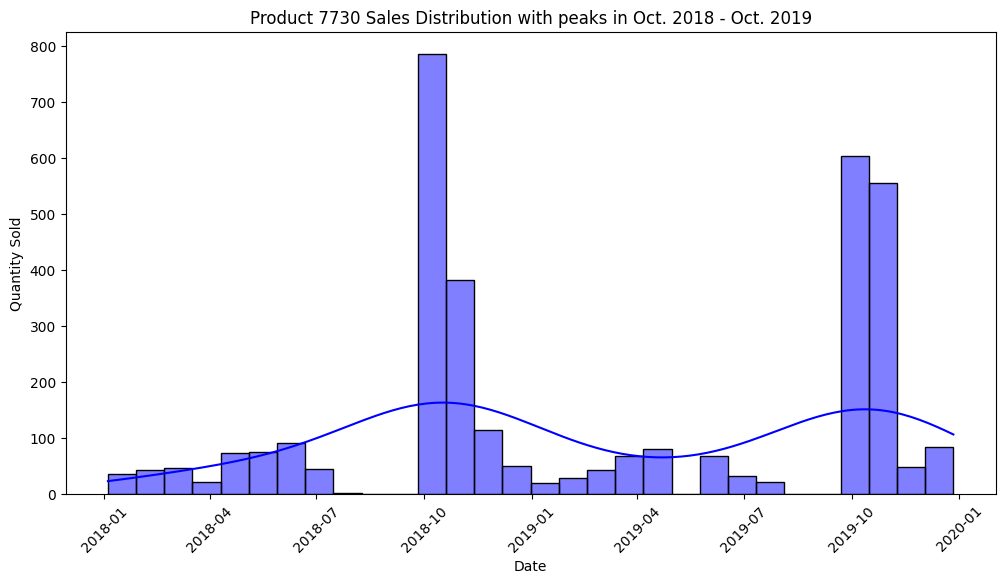

In [22]:
# Focus on product 7730 distribution (October 2018-2019 highest sales)

df = spark.sql('''
WITH product_7730_sales AS (
    SELECT 
        DATE(transaction_date) AS sale_date,
        SUM(quantity) AS total_quantity
    FROM df_2018_view
    WHERE 
        transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
        AND product = '7730'
    GROUP BY sale_date
)
SELECT 
    sale_date, 
    total_quantity
FROM product_7730_sales
ORDER BY sale_date;
''')

df_pandas = df.toPandas()

df_pandas['sale_date'] = pd.to_datetime(df_pandas['sale_date'])

plt.figure(figsize=(12, 6))
sns.histplot(df_pandas, x='sale_date', weights='total_quantity', bins=30, kde=True, color='blue')

plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.title("Product 7730 Sales Distribution with peaks in Oct. 2018 - Oct. 2019")
plt.xticks(rotation=45)

plt.show()


In [23]:
# List of customers repeatedly buying product 7730 more than once (Jan 2018 to December 2019)

spark.sql('''
SELECT 
    member_id AS repeated_member_id,
    COUNT(*) AS purchase_count
FROM df_2018_view
WHERE 
    product = '7730'
    AND transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
GROUP BY member_id
HAVING COUNT(*) > 1
ORDER BY purchase_count DESC;

''').show()

+------------------+--------------+
|repeated_member_id|purchase_count|
+------------------+--------------+
+------------------+--------------+



In [24]:
spark.sql('''
WITH product_7730_customers AS (
    SELECT DISTINCT member_id
    FROM df_2018_view
    WHERE product = '7730'
)

SELECT 
    df.category_name,
    COUNT(DISTINCT df.product) AS product_count
FROM df_2018_view df
JOIN product_7730_customers p7730
    ON df.member_id = p7730.member_id
WHERE df.product <> '7730'
GROUP BY df.category_name
ORDER BY product_count DESC
''').show()


+-------------+-------------+
|category_name|product_count|
+-------------+-------------+
|     CLEANERS|          270|
|         FOOD|          262|
|          PET|          254|
|     HARDWARE|          250|
|      GADGETS|          249|
|  ACCESSORIES|          248|
|  FROZEN FOOD|          248|
|        SHOES|          246|
|      CLOTHES|          243|
|   APPLIANCES|          237|
+-------------+-------------+



In [25]:
# List of customers who has bought product 7730

spark.sql('''
WITH monthly_sales AS (
    SELECT 
        DATE_TRUNC('month', transaction_date) AS sale_month,
        weather_list,
        temperature_list,
        realfell_list
    FROM df_2018_view
    WHERE product = '7730'
        AND transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
),

top_weather_per_month AS (
    SELECT 
        sale_month,
        weather_list,
        COUNT(*) AS weather_count,
        ROW_NUMBER() OVER (PARTITION BY sale_month ORDER BY COUNT(*) DESC) AS rnk
    FROM monthly_sales
    GROUP BY sale_month, weather_list
),

monthly_averages AS (
    SELECT 
        sale_month,
        ROUND(AVG(temperature_list), 2) AS avg_temperature,
        ROUND(AVG(realfell_list), 2) AS avg_realfeel
    FROM monthly_sales
    GROUP BY sale_month
)

SELECT 
    ma.sale_month,
    COALESCE(tw.weather_list, 'Unknown') AS top_weather_condition,
    ma.avg_temperature,
    ma.avg_realfeel
FROM monthly_averages ma
LEFT JOIN top_weather_per_month tw 
    ON ma.sale_month = tw.sale_month AND tw.rnk = 1
ORDER BY ma.sale_month ASC;


''').show()

+-------------------+---------------------+---------------+------------+
|         sale_month|top_weather_condition|avg_temperature|avg_realfeel|
+-------------------+---------------------+---------------+------------+
|2018-01-01 00:00:00|                Sunny|           28.5|        32.5|
|2018-02-01 00:00:00|        Mostly cloudy|          29.33|       33.33|
|2018-03-01 00:00:00| Partly sunny w sh...|          21.75|       25.75|
|2018-04-01 00:00:00|         Partly sunny|          27.29|       31.29|
|2018-05-01 00:00:00|  Intermittent clouds|          25.56|       29.56|
|2018-06-01 00:00:00|         Partly sunny|           26.5|        30.5|
|2018-07-01 00:00:00| Partly sunny w sh...|           18.0|        22.0|
|2018-08-01 00:00:00|               Cloudy|           23.0|        27.0|
|2018-10-01 00:00:00|              Showers|          26.18|       30.18|
|2018-11-01 00:00:00| Mostly cloudy w t...|           24.3|        28.3|
|2018-12-01 00:00:00| Partly sunny w sh...|        

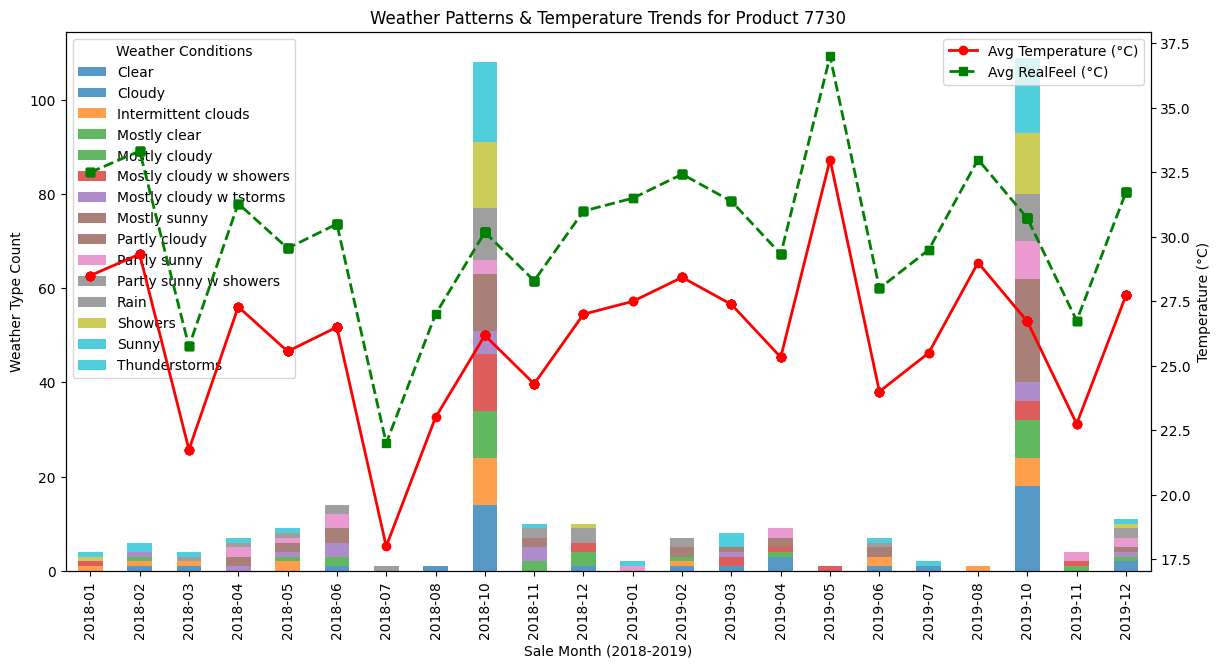

In [26]:
# Weather Patterns & Temperature Trends for Product 7730 (2018-2019)
df = spark.sql('''
WITH monthly_sales AS (
    SELECT 
        DATE_TRUNC('month', transaction_date) AS sale_month,
        weather_list,
        temperature_list,
        realfell_list
    FROM df_2018_view
    WHERE product = '7730'
        AND transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
),

weather_count_per_month AS (
    SELECT 
        sale_month,
        weather_list,
        COUNT(*) AS weather_count
    FROM monthly_sales
    GROUP BY sale_month, weather_list
),

monthly_averages AS (
    SELECT 
        sale_month,
        ROUND(AVG(temperature_list), 2) AS avg_temperature,
        ROUND(AVG(realfell_list), 2) AS avg_realfeel
    FROM monthly_sales
    GROUP BY sale_month
)

SELECT 
    wc.sale_month,
    wc.weather_list,
    wc.weather_count,
    ma.avg_temperature,
    ma.avg_realfeel
FROM weather_count_per_month wc
LEFT JOIN monthly_averages ma 
    ON wc.sale_month = ma.sale_month
ORDER BY wc.sale_month ASC;
''')

df_pandas = df.toPandas()

df_pandas["sale_month"] = pd.to_datetime(df_pandas["sale_month"]).dt.strftime('%Y-%m')

weather_pivot = df_pandas.pivot(index="sale_month", columns="weather_list", values="weather_count").fillna(0)

fig, ax1 = plt.subplots(figsize=(14, 7))

weather_pivot.plot(kind="bar", stacked=True, colormap="tab10", ax=ax1, alpha=0.75)

ax2 = ax1.twinx()
ax2.plot(df_pandas["sale_month"], df_pandas["avg_temperature"], color="red", marker="o", linestyle="-", linewidth=2, label="Avg Temperature (°C)")
ax2.plot(df_pandas["sale_month"], df_pandas["avg_realfeel"], color="green", marker="s", linestyle="--", linewidth=2, label="Avg RealFeel (°C)")

ax1.set_xlabel("Sale Month (2018-2019)")
ax1.set_ylabel("Weather Type Count")
ax2.set_ylabel("Temperature (°C)")
plt.title("Weather Patterns & Temperature Trends for Product 7730")

plt.xticks(rotation=45)

ax1.legend(loc="upper left", title="Weather Conditions")
ax2.legend(loc="upper right")

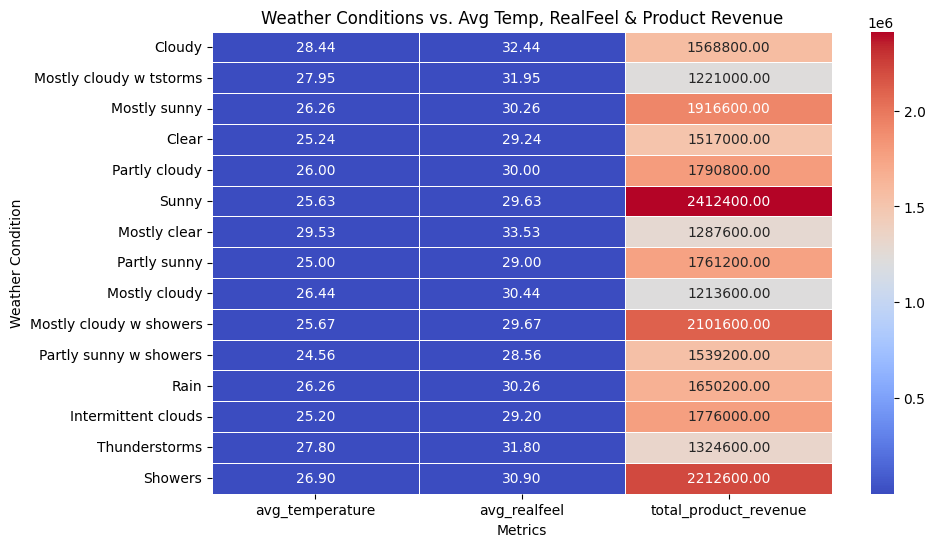

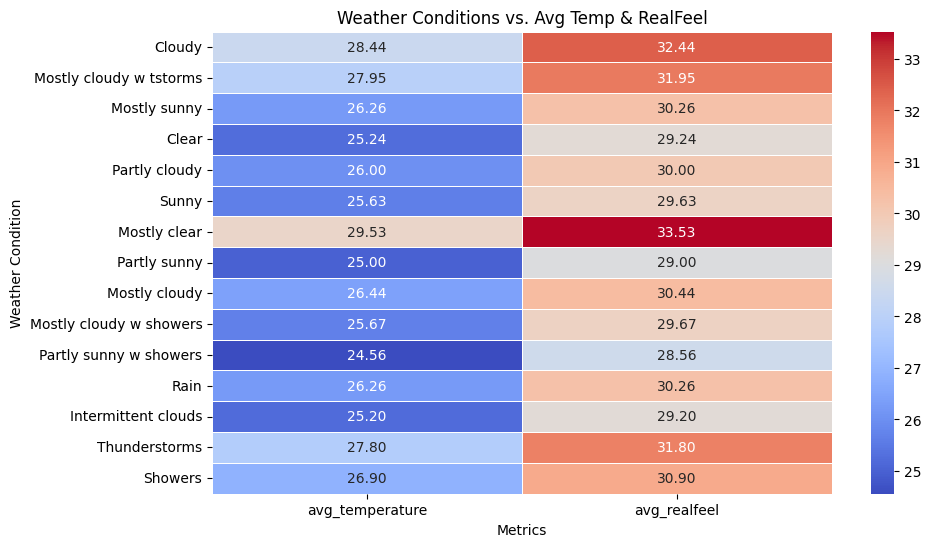

In [27]:
# Heatmap for each item in weather_list, average temperature, average realfell and product revenue

df_weather = spark.sql("""
    WITH weather_sales AS (
        SELECT 
            weather_list,
            ROUND(AVG(temperature_list), 2) AS avg_temperature,
            ROUND(AVG(realfell_list), 2) AS avg_realfeel,
            SUM(quantity * amount) AS total_product_revenue
        FROM df_2018_view
        WHERE product = '7730'
            AND transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
        GROUP BY weather_list
    )
    SELECT * FROM weather_sales
""").toPandas()

df_weather = df_weather.round(2)

df_weather.set_index("weather_list", inplace=True)

plt.figure(figsize=(10, 6))
sns.heatmap(df_weather, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Weather Conditions vs. Avg Temp, RealFeel & Product Revenue")
plt.xlabel("Metrics")
plt.ylabel("Weather Condition")

# Heatmap for Avg Temperature & RealFeel
plt.figure(figsize=(10, 6))
sns.heatmap(df_weather[['avg_temperature', 'avg_realfeel']], annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Weather Conditions vs. Avg Temp & RealFeel")
plt.xlabel("Metrics")
plt.ylabel("Weather Condition")
plt.show()

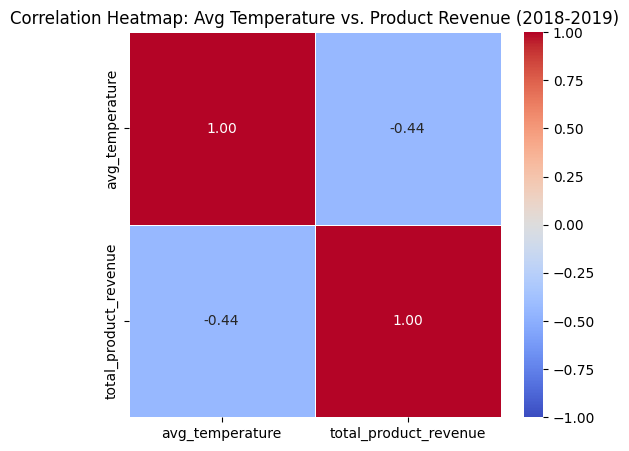

In [28]:
# Compute correlation matrix for avg_temperature & total_product_revenue

df_weather = spark.sql("""
    WITH weather_sales AS (
        SELECT 
            weather_list,
            ROUND(AVG(temperature_list), 2) AS avg_temperature,
            ROUND(AVG(realfell_list), 2) AS avg_realfeel,
            SUM(quantity * amount) AS total_product_revenue
        FROM df_2018_view
        WHERE product = '7730'
            AND transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
        GROUP BY weather_list
    )
    SELECT * FROM weather_sales
""").toPandas()

df_weather = df_weather.round(2)

correlation_matrix = df_weather[['avg_temperature', 'total_product_revenue']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)

plt.title("Correlation Heatmap: Avg Temperature vs. Product Revenue (2018-2019)")
plt.show()

In [29]:
# Summary statistics of non-aggregate weather and temperature values for Product 7730 (2018-2019)

df = spark.sql('''
WITH monthly_sales AS (
    SELECT 
        DATE_TRUNC('month', transaction_date) AS sale_month,
        member_id,
        age,
        branch,
        weather_list,
        temperature_list,
        realfell_list
    FROM df_2018_view
    WHERE product = '7730'
        AND transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
),

product_7730_revenue AS (
    SELECT
        DATE_TRUNC('month', transaction_date) AS sale_date,
        member_id,
        branch,
        (quantity * amount) AS product_7730_revenue
    FROM df_2018_view
    WHERE transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
        AND product = '7730'
)

SELECT 
    ms.member_id,
    ms.age,
    ms.sale_month,
    ms.branch,
    ms.weather_list,
    ms.temperature_list,
    ms.realfell_list,
    COALESCE(p7730.product_7730_revenue, 0) AS product_7730_revenue
FROM monthly_sales ms
LEFT JOIN product_7730_revenue p7730
    ON ms.sale_month = p7730.sale_date 
    AND ms.member_id = p7730.member_id
    AND ms.branch = p7730.branch
ORDER BY ms.sale_month ASC;
''')

pdf_sabt = df.toPandas()
pdf_sabt.head()

,member_id,age,sale_month,branch,weather_list,temperature_list,realfell_list,product_7730_revenue
0,004ca24c-cfdb-11eb-9811-d8f2ca37414f,55-60,2018-01-01,H,Mostly cloudy w showers,35,39,133200
1,fffd7085-cfda-11eb-ae60-d8f2ca37414f,55-60,2018-01-01,C,Showers,23,27,14800
2,010ce589-cfdb-11eb-82c9-d8f2ca37414f,30-35,2018-01-01,D,Intermittent clouds,26,30,37000
3,ff548ab6-cfda-11eb-9f5b-d8f2ca37414f,18-25,2018-01-01,C,Sunny,30,34,81400
4,ff04915d-cfda-11eb-941f-d8f2ca37414f,35-40,2018-02-01,A,Thunderstorms,22,26,59200


In [30]:
# Median of temperatures when products in the GADGETS category were bought

df_median_temp = spark.sql("""
    SELECT 
        transaction_date,
        product,
        approx_percentile(temperature_list, 0.5) AS median_temperature
    FROM df_2018_view
    WHERE category_name = 'GADGETS' 
        AND temperature_list IS NOT NULL
    GROUP BY transaction_date, product
    ORDER BY transaction_date
""")

df_median_temp.show()


+----------------+-------+------------------+
|transaction_date|product|median_temperature|
+----------------+-------+------------------+
|      2018-01-01|    222|                30|
|      2018-01-01|     22|                26|
|      2018-01-01|    356|                33|
|      2018-01-01|     57|                18|
|      2018-01-01|    511|                30|
|      2018-01-01|    114|                26|
|      2018-01-01|    585|                30|
|      2018-01-01|    141|                27|
|      2018-01-01|    614|                26|
|      2018-01-01|    177|                30|
|      2018-01-01|    638|                27|
|      2018-01-01|    255|                27|
|      2018-01-01|    726|                21|
|      2018-01-01|    326|                25|
|      2018-01-01|    832|                27|
|      2018-01-01|    357|                26|
|      2018-01-01|   3108|                25|
|      2018-01-01|    398|                27|
|      2018-01-01|   4381|        

In [31]:
# Overall median temperature for when GADGETS products were bought from 2018-2019

df_median_temp = spark.sql("""
    SELECT 
        approx_percentile(temperature_list, 0.5) AS overall_median_temperature
    FROM df_2018_view
    WHERE category_name = 'GADGETS' 
        AND temperature_list IS NOT NULL
        AND transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
""")

df_median_temp.show()

+--------------------------+
|overall_median_temperature|
+--------------------------+
|                        26|
+--------------------------+



In [ ]:
# Target definition of customers purchasing products from GADGETS at low (temp <= 26.0) or high temperatures (temp > 26)

# df = spark.sql('''
# WITH monthly_sales AS (
#     SELECT 
#         DATE_TRUNC('month', transaction_date) AS sale_month,
#         member_id,
#         age,
#         branch,
#         weather_list,
#         temperature_list,
#         realfell_list
#     FROM df_2018_view
#     WHERE category_name = 'GADGETS'
#         AND transaction_date BETWEEN '2018-01-01' AND '2019-12-31'
# )

# SELECT 
#     ms.member_id,
#     ms.age,
#     ms.sale_month,
#     ms.branch,
#     ms.weather_list,
#     ms.temperature_list,
#     ms.realfell_list,
#     -- Classification logic: 1 if customer buys in low temperature (<=26.0°C), otherwise 0
#     CASE 
#         WHEN ms.temperature_list <= 26.0 THEN 1
#         ELSE 0 
#     END AS target
# FROM monthly_sales ms
# ORDER BY ms.sale_month ASC;
# ''')

# pdf_sabt = df.toPandas()
# pdf_sabt.head()

,member_id,age,sale_month,branch,weather_list,temperature_list,realfell_list,target
0,011d174d-cfdb-11eb-a35b-d8f2ca37414f,35-40,2018-01-01,A,Intermittent clouds,31,35,0
1,fffc8656-cfda-11eb-bdbb-d8f2ca37414f,18-25,2018-01-01,B,Intermittent clouds,34,38,0
2,01161270-cfdb-11eb-84f4-d8f2ca37414f,40-45,2018-01-01,B,Mostly cloudy w showers,35,39,0
3,00c5f11b-cfdb-11eb-a7f9-d8f2ca37414f,55-60,2018-01-01,B,Mostly clear,33,37,0
4,ff3590cc-cfda-11eb-acc8-d8f2ca37414f,45-50,2018-01-01,C,Intermittent clouds,32,36,0


In [198]:
# Target definition of customers purchasing purchased Product 7730 (1) and customers who did not purchase Product 7730 (0)

df = spark.sql(''' 
WITH monthly_sales AS (
    SELECT 
        DATE_TRUNC('month', transaction_date) AS sale_month,
        member_id,
        age,
        branch,
        weather_list,
        temperature_list,
        realfell_list,
        SUM(quantity) AS total_quantity,
        SUM(amount) AS total_amount,
        MAX(CASE WHEN product = 7730 OR temperature_list <= 26.0 THEN 1 ELSE 0 END) AS purchased_7730
    FROM df_2018_view
    WHERE category_name = 'GADGETS'
        AND transaction_date BETWEEN '2019-05-01' AND '2019-10-31'
    GROUP BY sale_month, member_id, age, branch, weather_list, temperature_list, realfell_list
),

target_customers AS (
    SELECT DISTINCT member_id
    FROM monthly_sales
    WHERE sale_month BETWEEN '2019-08-01' AND '2019-10-31'
        AND purchased_7730 = 1
)

SELECT 
    ms.member_id,
    ms.age,
    ms.sale_month,
    ms.branch,
    ms.weather_list,
    ms.temperature_list,
    ms.realfell_list,
    ms.total_quantity AS quantity,
    ms.total_amount AS amount,
    CASE 
        WHEN tc.member_id IS NOT NULL THEN 1
        ELSE 0
    END AS target
FROM monthly_sales ms
LEFT JOIN target_customers tc 
ON ms.member_id = tc.member_id
WHERE ms.sale_month BETWEEN '2019-05-01' AND '2019-07-31'
ORDER BY ms.sale_month ASC;
''')
pdf_sabt = df.toPandas()
pdf_sabt.head()

,member_id,age,sale_month,branch,weather_list,temperature_list,realfell_list,quantity,amount,target
0,01268d28-cfdb-11eb-a7c8-d8f2ca37414f,55-60,2019-05-01,C,Mostly clear,28,32,8,9000,0
1,fefcc92f-cfda-11eb-98ac-d8f2ca37414f,50-55,2019-05-01,F,Sunny,22,26,28,15700,0
2,008208b1-cfdb-11eb-9076-d8f2ca37414f,45-50,2019-05-01,I,Cloudy,28,32,1,3700,0
3,ffa25eb6-cfda-11eb-a75f-d8f2ca37414f,45-50,2019-05-01,F,Showers,18,22,5,2500,0
4,004c5473-cfdb-11eb-8fe3-d8f2ca37414f,45-50,2019-05-01,C,Showers,25,29,8,7300,0


In [203]:
# Check column names in data
pdf_sabt.columns

Index(['member_id', 'age', 'sale_month', 'branch', 'weather_list',
       'temperature_list', 'realfell_list', 'quantity', 'amount', 'target'],
      dtype='object')

In [200]:
# Check summary statistics
pdf_sabt[['member_id', 'age', 'sale_month', 'branch', 'weather_list',
       'temperature_list', 'realfell_list', 'quantity', 'amount', 'target']].describe().T

,count,mean,min,25%,50%,75%,max,std
sale_month,47322,2019-05-22 23:40:05.933815296,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,NaN
temperature_list,47322.0,26.430941,18.0,22.0,26.0,31.0,35.0,5.168268
realfell_list,47322.0,30.430941,22.0,26.0,30.0,35.0,39.0,5.168268
quantity,47322.0,10.547504,1.0,5.0,10.0,15.0,53.0,6.124367
amount,47322.0,5144.596594,100.0,2600.0,4600.0,7700.0,31300.0,3106.521624
target,47322.0,0.021766,0.0,0.0,0.0,0.0,1.0,0.145919


In [ ]:
pdf_sabt.groupby(['target'])[['temperature_list', 
'realfell_list', 'quantity', 'amount']].describe().T

target                             0             1
temperature_list count  46292.000000   1030.000000
                 mean      26.433055     26.335922
                 std        5.167998      5.181991
                 min       18.000000     18.000000
                 25%       22.000000     22.000000
                 50%       26.000000     26.000000
                 75%       31.000000     31.000000
                 max       35.000000     35.000000
realfell_list    count  46292.000000   1030.000000
                 mean      30.433055     30.335922
                 std        5.167998      5.181991
                 min       22.000000     22.000000
                 25%       26.000000     26.000000
                 50%       30.000000     30.000000
                 75%       35.000000     35.000000
                 max       39.000000     39.000000
quantity         count  46292.000000   1030.000000
                 mean      10.538927     10.933010
                 std        6.123115      6.171061
                 min        1.000000      1.000000
                 25%        5.000000      6.000000
                 50%       10.000000     11.000000
                 75%       15.000000     16.000000
                 max       53.000000     41.000000
amount           count  46292.000000   1030.000000
                 mean    5145.346928   5110.873786
                 std     3106.599352   3104.346339
                 min      100.000000    100.000000
                 25%     2600.000000   2525.000000
                 50%     4600.000000   4600.000000
                 75%     7700.000000   7600.000000
                 max    31300.000000  22000.000000

In [202]:
data = pdf_sabt[['member_id', 'age', 'sale_month', 'branch', 'weather_list',
       'temperature_list', 'realfell_list', 'quantity', 'amount', 'target']].copy()

In [191]:
# Separate target variable and features
from sklearn.model_selection import train_test_split

target_col = 'target'

X = data.loc[:, data.columns != target_col]
y = data.loc[:, target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print(f'Training set size: {X_train.shape[0]} samples')
print(f'Testing set size: {X_test.shape[0]} samples')

Training set size: 23661 samples
Testing set size: 23661 samples


In [192]:
X_train.head()

,member_id,age,sale_month,branch,weather_list,temperature_list,realfell_list,quantity,amount
42687,ff1c8bd8-cfda-11eb-99e2-d8f2ca37414f,50-55,2019-07-01,A,Partly sunny w showers,34,38,13,7700
37795,ffd99b85-cfda-11eb-add3-d8f2ca37414f,55-60,2019-06-01,H,Clear,19,23,4,1100
33118,ff094c3f-cfda-11eb-b8cb-d8f2ca37414f,50-55,2019-06-01,B,Mostly cloudy w tstorms,24,28,14,1600
2047,ffbd8817-cfda-11eb-b3f1-d8f2ca37414f,45-50,2019-05-01,I,Partly sunny,34,38,8,400
1495,00452843-cfdb-11eb-8882-d8f2ca37414f,40-45,2019-05-01,D,Partly sunny,28,32,3,9600


In [193]:
y_train.head()

42687    0
37795    0
33118    0
2047     0
1495     0
Name: target, dtype: int32

In [194]:
print(y_train.value_counts())
print(y_test.value_counts())

target
0    23139
1      522
Name: count, dtype: int64
target
0    23153
1      508
Name: count, dtype: int64


In [195]:
from catboost import CatBoostClassifier

X_train = X_train.astype(str)
X_test = X_test.astype(str)

cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=50, eval_metric='F1')

model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 95.8ms	remaining: 47.8s
50:	learn: 0.0630798	test: 0.1185185	best: 0.1185185 (23)	total: 6.23s	remaining: 54.9s
100:	learn: 0.0630798	test: 0.1185185	best: 0.1185185 (23)	total: 13.1s	remaining: 51.6s
150:	learn: 0.0702403	test: 0.1185185	best: 0.1185185 (23)	total: 21s	remaining: 48.6s
200:	learn: 0.0702403	test: 0.1185185	best: 0.1185185 (23)	total: 29.2s	remaining: 43.4s
250:	learn: 0.0773481	test: 0.1185185	best: 0.1185185 (23)	total: 37.5s	remaining: 37.2s
300:	learn: 0.0879121	test: 0.1185185	best: 0.1185185 (23)	total: 46.9s	remaining: 31s
350:	learn: 0.0948905	test: 0.1185185	best: 0.1185185 (23)	total: 1m 5s	remaining: 27.9s
400:	learn: 0.0983607	test: 0.1185185	best: 0.1185185 (23)	total: 1m 16s	remaining: 18.9s
450:	learn: 0.1052632	test: 0.1185185	best: 0.1185185 (23)	total: 1m 24s	remaining: 9.2s
499:	learn: 0.1121157	test: 0.1185185	best: 0.1185185 (23)	total: 1m 33s	remaining: 0us

bestTest = 0.1185185185
bes

In [196]:
y_pred = model.predict(X_test)

print(f'Predictions: {y_pred[:50]}')

Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


Accuracy: 0.9799
F1: 0.1185
Precision: 1.0000
Recall: 0.0630

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     23153
           1       1.00      0.06      0.12       508

    accuracy                           0.98     23661
   macro avg       0.99      0.53      0.55     23661
weighted avg       0.98      0.98      0.97     23661

[[23153     0]
 [  476    32]]


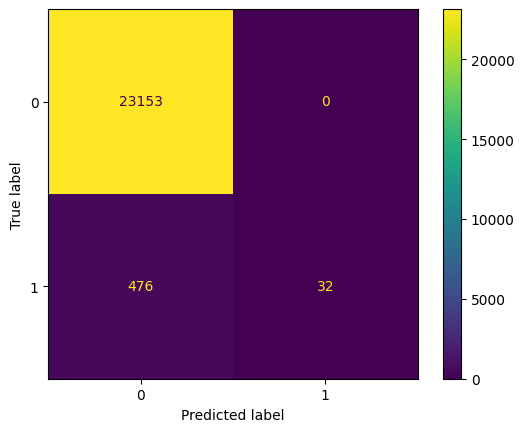

In [197]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'F1: {f1_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm_train = confusion_matrix(y_test, y_pred)
print(cm_train)

cmd_train = ConfusionMatrixDisplay(cm_train)
cmd_train.plot()

In [204]:
#### Set model name

prefix_name="temperature_based_gadget_purchases"

model_name = f"churn_prediction_{get_datetime()}_{prefix_name}"
print(f"{model_name}")

20250328_2248
churn_prediction_20250328_2248_temperature_based_gadget_purchases


In [205]:
#### Save model

import pickle

# Save the model using pickle
with open(f"{model_name}.pkl", "wb") as file:
    pickle.dump(model, file)

print(f"Model saved as {model_name}.pkl")

Model saved as churn_prediction_20250328_2248_temperature_based_gadget_purchases.pkl


In [210]:
#### Retrieve model

model_name = 'churn_prediction_20250328_2248_temperature_based_gadget_purchases'

with open(f'{home_dir}/models/{model_name}.pkl', 'rb') as f:
  loaded_pipeline = pickle.load(f)

print(f'Model {model_name} ready!')

Model churn_prediction_20250328_2248_temperature_based_gadget_purchases ready!


In [213]:
# Separate target variable and features
y_oot = data['target']
X_oot = data.drop(['target'], axis=1)

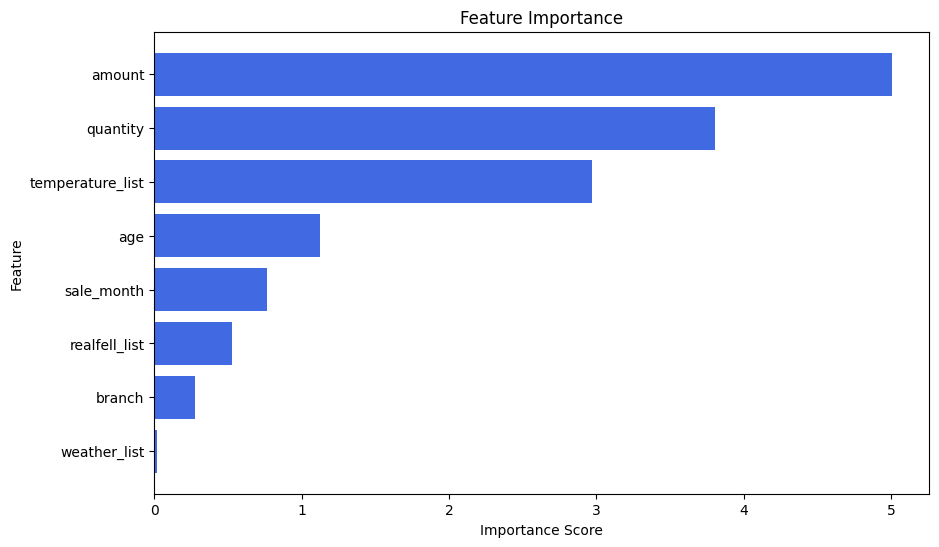

In [218]:
#### Get coefficients & intercept

import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance
feature_importance = model.get_feature_importance()
feature_names = X.columns  # Assuming X is your feature DataFrame

# Create a DataFrame for plotting
importance_df = importance_df[importance_df["Feature"] != "member_id"]
importance_df = importance_df.sort_values(by="Importance", ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="royalblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()